The dataset has 60000 images (50000 for training, 10000 for testing) of classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. <br>
The images in CIFAR-10 are of size 3x32x32

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
from torchvision import transforms, datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Loading data

In [5]:
trainset = datasets.CIFAR10(root='./data', train=True, download=True,
                       transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))

testset = datasets.CIFAR10('./data', train=False, download=True,
                       transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))

trainloader = torch.utils.data.DataLoader(trainset, batch_size=50, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=50, shuffle=True, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Printing some samples

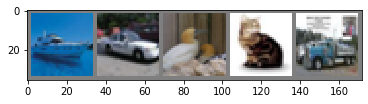

Labels:  ship   car  bird   cat truck


In [6]:
def imshow(img):           #img is a grid with size of (3,32+2*2,5*32+2*6) with spacing = 2
    img = img / 2 + 0.5    # unnormalize pixel values
    npimg = img.numpy()

    plt.imshow(np.transpose(npimg, (1, 2, 0)))    #convert size of (channels, heighth, width) to (heighth, width, channels)
    plt.show()

#iterate a batch get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

#make a grid and show images
imshow(torchvision.utils.make_grid(images[:5]))     #make a image grid from a list of images
# print labels
print("Labels:",' '.join('%5s' % classes[labels[j]] for j in range(5)))

# Building the model
Output dimension = ((I-K+2P)/S + 1)

In [18]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3) 
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.batch = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64 * 6 * 6, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))                                   #output.size=(50,32,15,15)
        x = self.batch(self.pool2(F.relu(self.conv2(x))))                        #output.size=(50,64,6,6)
        x = x.view(-1, 64 * 6 * 6)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Feeding data and training the model

In [20]:
for epoch in range(5):  

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 500 == 499:    # print every 500 iterations (total is 1000 iterations=60000/60)
            print('[Epoch: %d, Training samples: %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[Epoch: 1, Training samples:   500] loss: 0.467
[Epoch: 1, Training samples:  1000] loss: 0.339
[Epoch: 2, Training samples:   500] loss: 0.290
[Epoch: 2, Training samples:  1000] loss: 0.260
[Epoch: 3, Training samples:   500] loss: 0.232
[Epoch: 3, Training samples:  1000] loss: 0.221
[Epoch: 4, Training samples:   500] loss: 0.200
[Epoch: 4, Training samples:  1000] loss: 0.194
[Epoch: 5, Training samples:   500] loss: 0.176
[Epoch: 5, Training samples:  1000] loss: 0.172
Finished Training


Save the model parameters

In [21]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

# Evaluating the model's performance on test data

Load the model parameters, so that I don't have to train the model again 

In [23]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [33]:
correct = 0
total = 0   #10000

with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()    #check if each elements of predicted tensor is equal to labels,
                                                         #return a tensor with value 1(accurate) or 0(not) then add the values up

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 71 %


Check the accuracy on each class

In [41]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(50):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 78 %
Accuracy of   car : 80 %
Accuracy of  bird : 61 %
Accuracy of   cat : 43 %
Accuracy of  deer : 70 %
Accuracy of   dog : 70 %
Accuracy of  frog : 79 %
Accuracy of horse : 71 %
Accuracy of  ship : 79 %
Accuracy of truck : 83 %


Print some predictions

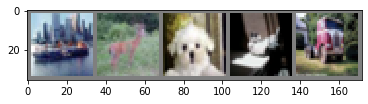

Groundtruth:  ship  deer   dog   cat truck


In [38]:
dataiter = iter(testloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images[:5]))     #make a image grid from a list of images
# print labels
print("Groundtruth:",' '.join('%5s' % classes[labels[j]] for j in range(5)))

In [39]:
outputs = net(images)
_, predicted = torch.max(outputs, 1)         #get value and index tensor of max values of outputs tensor

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(5)))

Predicted:   ship  deer   dog   cat truck
